# Analisis Exploratorio de baches de la Marginación Social por AGEB

Primero que nada importemos los modulos que son necesarios pra este analisis

In [36]:
import os 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from shapely.geometry import Point

Localizamos el directorio del proyecto

In [37]:
directorio = os.path.dirname(os.getcwd())

Leemos los archicos tidy que utilizaremos y eliminamos los datos inecesarios

In [38]:
baches = gpd.read_file(directorio + '/data/processed/tidy_baches_agebs_hmo.shp')
baches.CVEGEO = baches.CVEGEO.str[-4:]
se_ageb = gpd.read_file(directorio + '/data/processed/tidy_socioeconimico_ageb_hermosillo.shp')
se = pd.read_csv(directorio + '/data/processed/tidy_socioeconomico_hermosillo.csv')


In [39]:
baches = baches[baches['CVEGEO'].isin(se_ageb.CVEGEO.to_list())]
baches = baches.dropna()

In [40]:
# Convertir a un sistema de referencia proyectado (metros) para medir distancias
gdf = baches.to_crs("EPSG:3857")

# Extraer las coordenadas de los puntos en metros
coordinates = [(geom.x, geom.y) for geom in gdf.geometry]

# Crear un KDTree con las coordenadas para encontrar vecinos cercanos
tree = KDTree(coordinates)
processed_indices = set()
new_data = []

# Recorrer cada punto en el GeoDataFrame
for i, point in enumerate(coordinates):
    if i in processed_indices:
        continue
    
    # Encontrar puntos dentro de un radio de 2 metros
    indices = tree.query_ball_point(point, r=2)
    processed_indices.update(indices)
    
    # Filtrar el GeoDataFrame original para estos índices
    close_points = gdf.iloc[indices]

    # Elegir un punto aleatorio de los puntos cercanos
    random_point = close_points.geometry.sample(1).iloc[0]  # Elige aleatoriamente un punto

    # Obtener la fecha más antigua y un `CVEGEO` al azar
    oldest_date = close_points['date'].min()
    random_ageb = close_points['CVEGEO'].sample(1).iloc[0]  # Elegir un `CVEGEO` al azar

    # Guardar el resultado en una lista
    new_data.append({
        "date": oldest_date,
        "CVEGEO": random_ageb,
        "geometry": random_point  # Usar el punto aleatorio seleccionado
    })

# Crear un nuevo GeoDataFrame con los resultados
new_gdf = gpd.GeoDataFrame(new_data, geometry="geometry", crs="EPSG:3857")

# Opcional: Convertir de nuevo a EPSG:4326 si necesitas las coordenadas originales
new_gdf = new_gdf.to_crs("EPSG:4326")


In [41]:
baches = new_gdf

### Baches de Hermosillo

Graficamos los Agebs de Hermosillo hacemos distinciones por ageb y además agregamos los baches

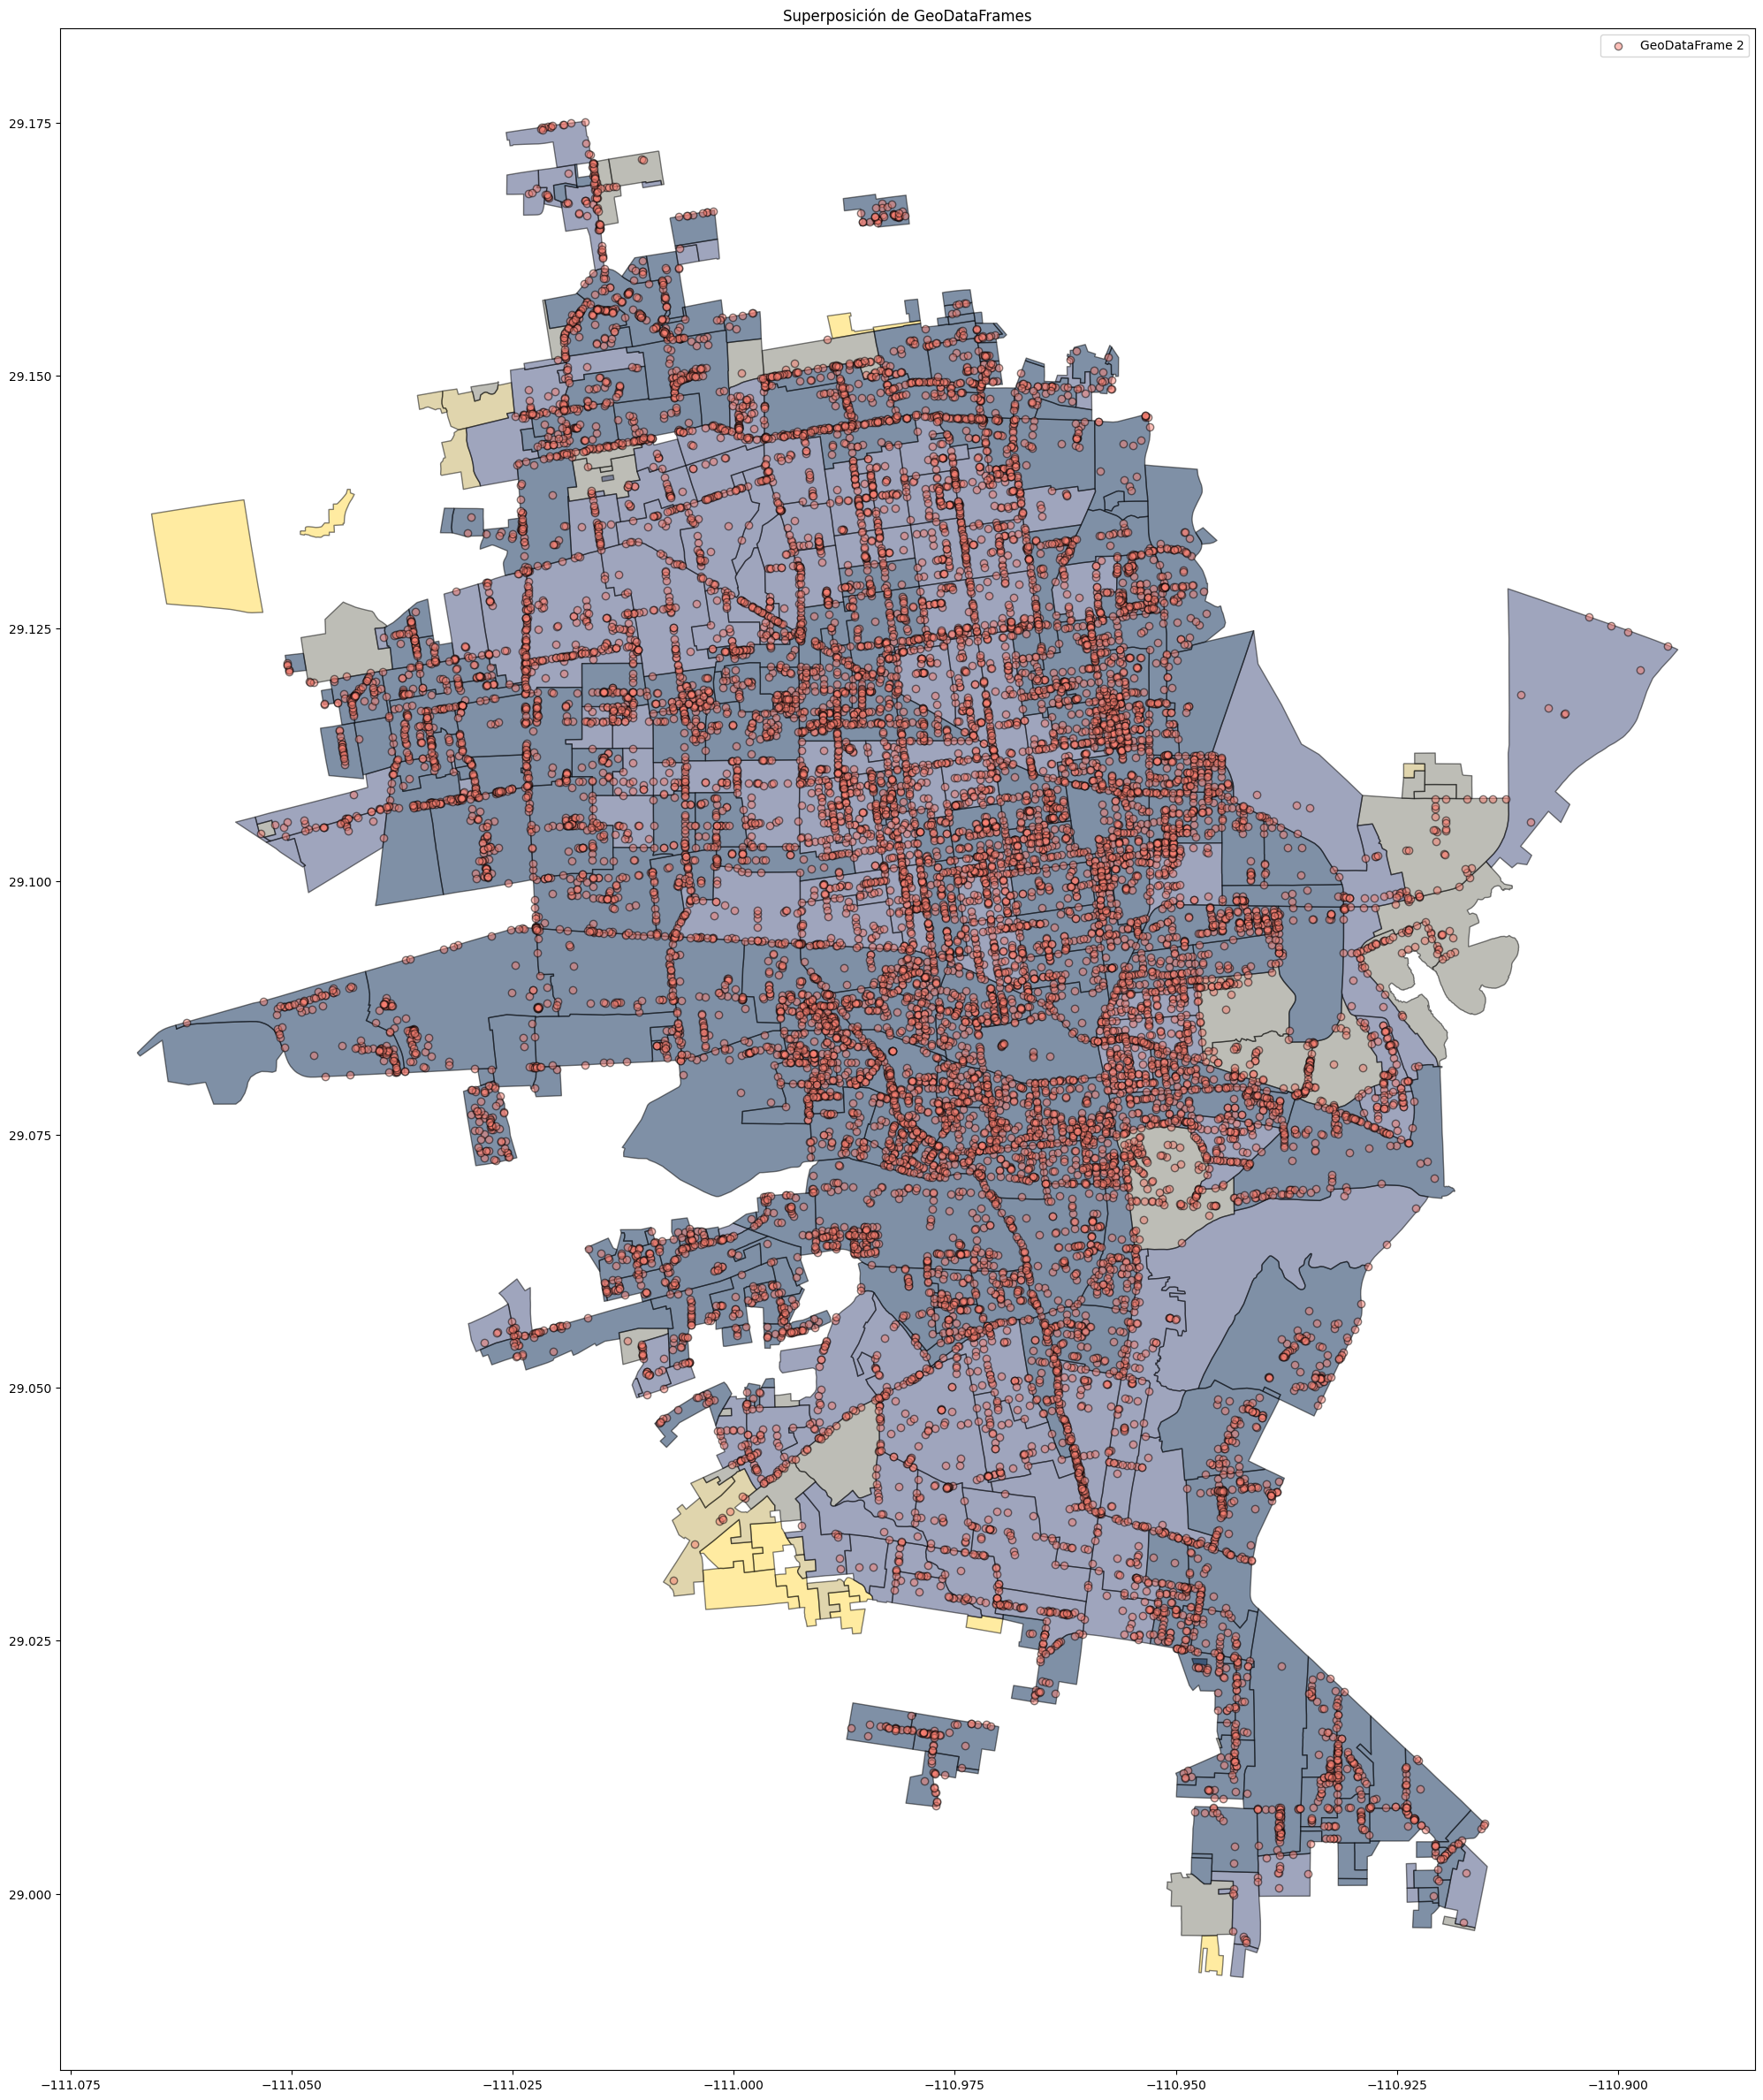

In [42]:
fig, ax = plt.subplots(figsize=(30,30))
se_ageb[se_ageb.GM_2020 == 'Muy alto'].plot(ax=ax, color="#FFD945", edgecolor="black", alpha=0.5)
se_ageb[se_ageb.GM_2020 == 'Alto'].plot(ax=ax, color="#C2AC5C", edgecolor="black", alpha=0.5)
se_ageb[se_ageb.GM_2020 == 'Medio'].plot(ax=ax, color="#7D7D6E", edgecolor="black", alpha=0.5)
se_ageb[se_ageb.GM_2020 == 'Bajo'].plot(ax=ax, color="#414C7D", edgecolor="black", alpha=0.5)
se_ageb[se_ageb.GM_2020 == 'Muy bajo'].plot(ax=ax, color="#00224E", edgecolor="black", alpha=0.5)

baches.plot(ax=ax, color="salmon", edgecolor="black", alpha=0.5, label="GeoDataFrame 2")

# Agregar leyenda y título
plt.legend()
plt.title("Superposición de GeoDataFrames")
plt.show()

In [43]:
total_baches_ageb = baches.groupby('CVEGEO',as_index=False).size().sort_values(by="size")
total_baches_ageb = se_ageb.merge(total_baches_ageb, on='CVEGEO', how='left')
total_baches_ageb['total_baches'] = total_baches_ageb['size'] 
total_baches_ageb = total_baches_ageb.drop(columns=['size']) 
total_baches_ageb.total_baches.fillna(0,inplace=True)

/var/folders/k1/mgsx4x9n5zb6hdwy4z831rrw0000gn/T/ipykernel_5928/3198832451.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  total_baches_ageb.total_baches.fillna(0,inplace=True)


#### Aquí veamos las AGEBS con mayor número de baches

In [44]:
total_baches_ageb.sort_values(by='total_baches', ascending=False).head(10)

,CVEGEO,POB_TOT,IM_2020,GM_2020,IMN_2020,geometry,total_baches
241,2710,8006,126.351538,Muy bajo,0.987011,"POLYGON ((-110.99039 29.07243, -110.98956 29.0...",231.0
14,1873,2237,125.758180,Muy bajo,0.982376,"POLYGON ((-110.96018 29.10952, -110.95867 29.1...",180.0
2,2246,14443,123.411364,Bajo,0.964043,"POLYGON ((-111.02225 29.11919, -111.02225 29.1...",173.0
240,2655,1860,126.310199,Muy bajo,0.986688,"POLYGON ((-110.9898 29.08529, -110.99126 29.08...",162.0
62,4863,8169,124.630666,Muy bajo,0.973568,"POLYGON ((-110.95917 29.14553, -110.95916 29.1...",160.0
85,3032,726,126.052970,Muy bajo,0.984679,"POLYGON ((-110.95807 29.08072, -110.95803 29.0...",153.0
36,2443,3672,125.877643,Muy bajo,0.983309,"POLYGON ((-110.95401 29.12302, -110.95299 29.1...",151.0
233,2956,2410,123.774804,Muy bajo,0.966882,"POLYGON ((-110.97733 29.07822, -110.9774 29.07...",149.0
97,2890,2769,124.244193,Muy bajo,0.970549,"POLYGON ((-110.9866 29.12137, -110.98568 29.12...",145.0
23,2015,1146,125.156191,Muy bajo,0.977673,"POLYGON ((-110.94962 29.09777, -110.94941 29.0...",140.0


#### Creamos una lista con los AGEB con mayo numero de baches

In [45]:
ageb_mas_baches = total_baches_ageb.sort_values(by='total_baches', ascending=False)['CVEGEO']
ageb_mas_baches = ageb_mas_baches.head(10).to_list()

#### Cambiamos el crs del dataframe $total\_baches\_ageb$ para calcular el áera en metros cuadrados", y lo regresamos al crs 4326

In [46]:
total_baches_ageb = total_baches_ageb.to_crs("EPSG:32614")
total_baches_ageb['area_ageb'] = total_baches_ageb.geometry.area 
total_baches_ageb['area_ageb'] = total_baches_ageb['area_ageb'].round(2)
total_baches_ageb = total_baches_ageb.to_crs("EPSG:4326")

#### Graficamos los 10 AGEB con mas baches

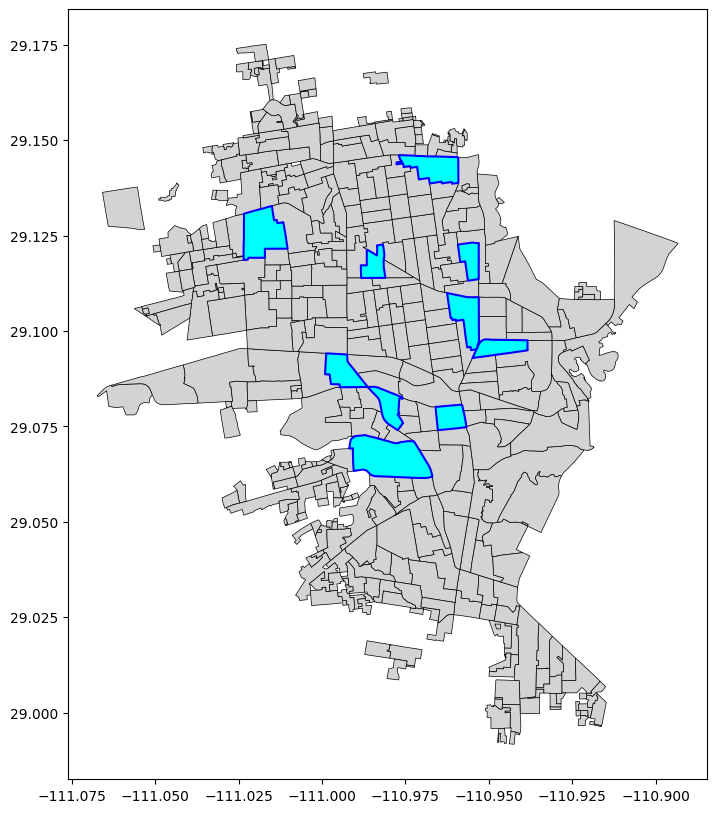

In [47]:
total_baches_ageb['es_destacada'] = total_baches_ageb['CVEGEO'].isin(ageb_mas_baches)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
total_baches_ageb[~total_baches_ageb['es_destacada']].plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)  # Colonias no destacadas
total_baches_ageb[total_baches_ageb['es_destacada']].plot(ax=ax, color='cyan', edgecolor='blue', linewidth=1.5)        # Colonias destacadas

plt.show()
total_baches_ageb = total_baches_ageb.drop(columns=['es_destacada'])

In [48]:
total_baches_ageb[total_baches_ageb.total_baches == 0]

,CVEGEO,POB_TOT,IM_2020,GM_2020,IMN_2020,geometry,total_baches,area_ageb
140,5664,1156,124.168472,Muy bajo,0.969958,"POLYGON ((-110.93163 29.00149, -110.93163 29.0...",0.0,87229.33
157,5895,89,117.785721,Alto,0.920098,"POLYGON ((-110.99342 29.03449, -110.99355 29.0...",0.0,23588.26
158,5908,64,121.630978,Bajo,0.950136,"POLYGON ((-111.01492 29.13997, -111.01361 29.1...",0.0,6649.04
160,6874,628,114.974862,Muy alto,0.898141,"POLYGON ((-110.97353 29.02747, -110.97329 29.0...",0.0,58854.89
163,5927,397,120.621359,Medio,0.942249,"POLYGON ((-110.92185 29.10958, -110.92066 29.1...",0.0,64469.78
...,...,...,...,...,...,...,...,...
389,7406,92,107.881809,Muy alto,0.842732,"POLYGON ((-110.994 29.03044, -110.99467 29.030...",0.0,147803.36
393,896A,305,99.450176,Muy alto,0.776867,"POLYGON ((-110.98885 29.15381, -110.98895 29.1...",0.0,68036.87
400,8921,222,98.191425,Muy alto,0.767035,"POLYGON ((-111.04899 29.13464, -111.04843 29.1...",0.0,91874.27
401,8936,106,111.785187,Muy alto,0.873224,"POLYGON ((-111.06553 29.13469, -111.06577 29.1...",0.0,1196942.17


#### Numero de agebs por nivel con marginación social

In [49]:
total_baches_ageb.groupby('GM_2020').size()

GM_2020
Alto          9
Bajo        123
Medio        30
Muy alto     12
Muy bajo    230
dtype: int64

#### Cero baches reportados en las siguientes AGEBS

In [50]:
cero_bache = total_baches_ageb[total_baches_ageb.total_baches == 0]['CVEGEO'].to_list()
total_baches_ageb[total_baches_ageb.total_baches == 0]

,CVEGEO,POB_TOT,IM_2020,GM_2020,IMN_2020,geometry,total_baches,area_ageb
140,5664,1156,124.168472,Muy bajo,0.969958,"POLYGON ((-110.93163 29.00149, -110.93163 29.0...",0.0,87229.33
157,5895,89,117.785721,Alto,0.920098,"POLYGON ((-110.99342 29.03449, -110.99355 29.0...",0.0,23588.26
158,5908,64,121.630978,Bajo,0.950136,"POLYGON ((-111.01492 29.13997, -111.01361 29.1...",0.0,6649.04
160,6874,628,114.974862,Muy alto,0.898141,"POLYGON ((-110.97353 29.02747, -110.97329 29.0...",0.0,58854.89
163,5927,397,120.621359,Medio,0.942249,"POLYGON ((-110.92185 29.10958, -110.92066 29.1...",0.0,64469.78
...,...,...,...,...,...,...,...,...
389,7406,92,107.881809,Muy alto,0.842732,"POLYGON ((-110.994 29.03044, -110.99467 29.030...",0.0,147803.36
393,896A,305,99.450176,Muy alto,0.776867,"POLYGON ((-110.98885 29.15381, -110.98895 29.1...",0.0,68036.87
400,8921,222,98.191425,Muy alto,0.767035,"POLYGON ((-111.04899 29.13464, -111.04843 29.1...",0.0,91874.27
401,8936,106,111.785187,Muy alto,0.873224,"POLYGON ((-111.06553 29.13469, -111.06577 29.1...",0.0,1196942.17


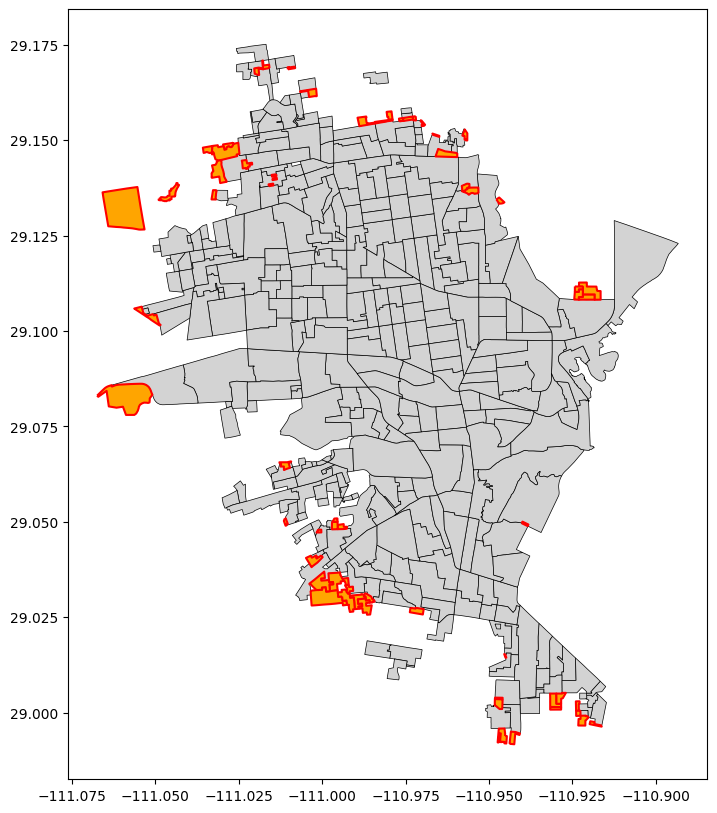

In [ ]:
total_baches_ageb['es_destacada'] = total_baches_ageb['CVEGEO'].isin(cero_bache)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
total_baches_ageb[~total_baches_ageb['es_destacada']].plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)  # Colonias no destacadas
total_baches_ageb[total_baches_ageb['es_destacada']].plot(ax=ax, color='cyan', edgecolor='blue', linewidth=1.5)        # Colonias destacadas

plt.show()
total_baches_ageb = total_baches_ageb.drop(columns=['es_destacada'])

#### Un bache reportado en las siguientes AGEBS

In [52]:
un_bache = total_baches_ageb[total_baches_ageb.total_baches == 1]['CVEGEO'].to_list()
total_baches_ageb[total_baches_ageb.total_baches == 1]

,CVEGEO,POB_TOT,IM_2020,GM_2020,IMN_2020,geometry,total_baches,area_ageb
205,7035,715,122.827166,Bajo,0.959480,"POLYGON ((-111.00625 29.16091, -111.00628 29.1...",1.0,44758.28
255,7213,915,118.814886,Medio,0.928137,"POLYGON ((-111.00055 29.14883, -111.00061 29.1...",1.0,179617.36
273,6802,2423,120.602209,Medio,0.942099,"POLYGON ((-110.94827 29.00193, -110.94814 29.0...",1.0,391488.89
279,7548,79,127.067376,Muy bajo,0.992603,"POLYGON ((-111.02861 29.07982, -111.0287 29.08...",1.0,26605.32
282,7571,104,126.982365,Muy bajo,0.991939,"POLYGON ((-111.00753 29.15566, -111.00738 29.1...",1.0,13849.60
301,7482,1259,126.423221,Muy bajo,0.987571,"POLYGON ((-111.02332 29.1112, -111.0233 29.110...",1.0,3512.40
302,7497,367,124.251731,Muy bajo,0.970608,"POLYGON ((-111.03143 29.11121, -111.02961 29.1...",1.0,22276.36
322,6395,392,120.798989,Medio,0.943636,"POLYGON ((-111.0012 29.04201, -111.00031 29.04...",1.0,41429.37
329,7336,559,126.171167,Muy bajo,0.985602,"POLYGON ((-110.92258 29.00057, -110.92034 29.0...",1.0,35381.30
332,7868,927,125.339529,Muy bajo,0.979105,"POLYGON ((-110.92066 29.00373, -110.92093 29.0...",1.0,35263.99


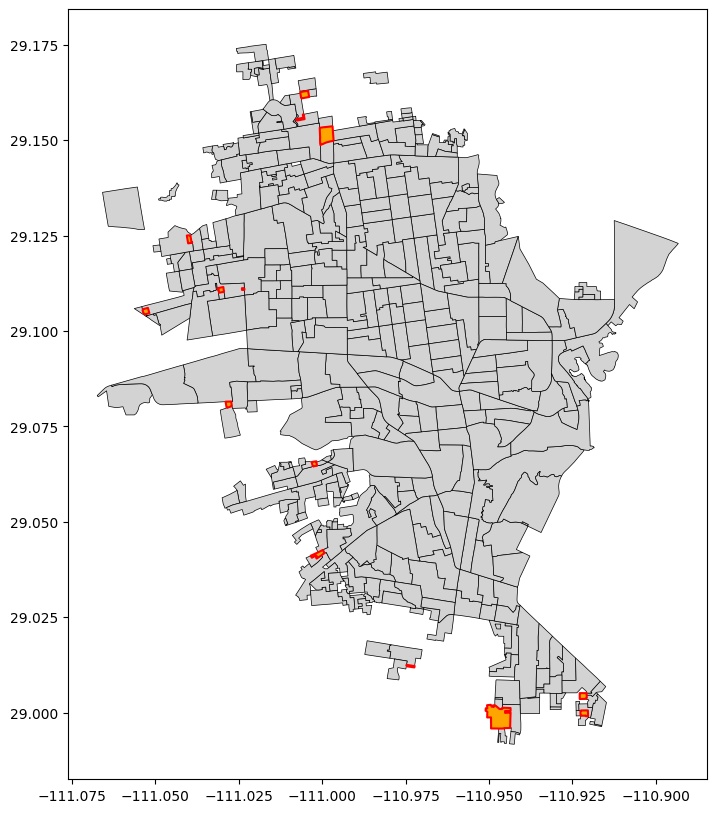

In [ ]:
total_baches_ageb['es_destacada'] = total_baches_ageb['CVEGEO'].isin(un_bache)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
total_baches_ageb[~total_baches_ageb['es_destacada']].plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)  # Colonias no destacadas
total_baches_ageb[total_baches_ageb['es_destacada']].plot(ax=ax, color='cyan', edgecolor='blue', linewidth=1.5)        # Colonias destacadas

plt.show()
total_baches_ageb = total_baches_ageb.drop(columns=['es_destacada'])

#### Calculamos el numero de baches por metro cuadrado

In [54]:
total_baches_ageb['baches_por_metro2'] = total_baches_ageb.total_baches / total_baches_ageb.area_ageb

In [55]:
baches_por_area = total_baches_ageb.sort_values(by='baches_por_metro2',ascending=False).head(10)['CVEGEO'].to_list()

#### Graficamos el las 10 AGEBS con más baches por metro cuadrado

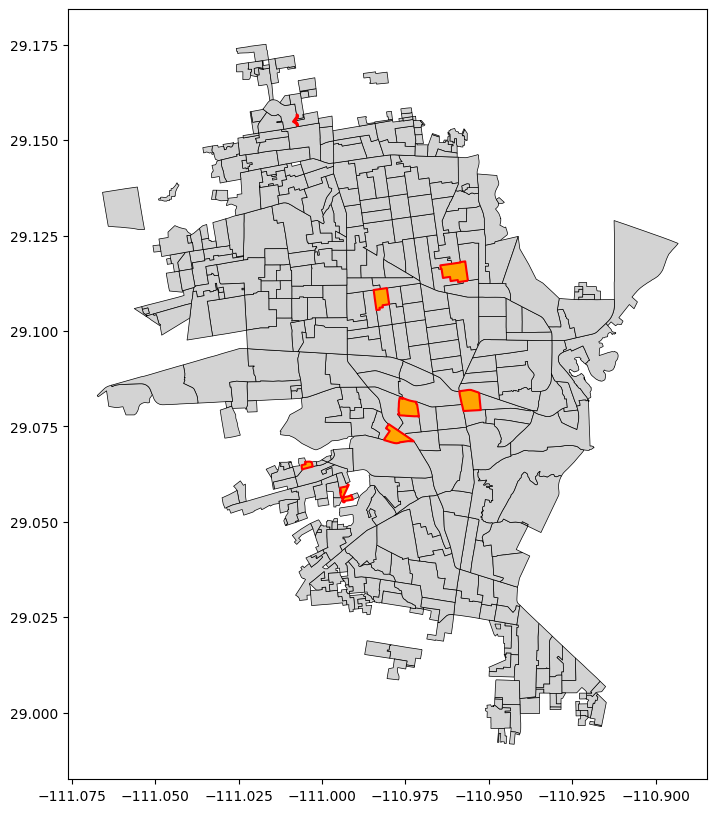

In [ ]:
total_baches_ageb['es_destacada'] = total_baches_ageb['CVEGEO'].isin(baches_por_area)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
total_baches_ageb[~total_baches_ageb['es_destacada']].plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)  # Colonias no destacadas
total_baches_ageb[total_baches_ageb['es_destacada']].plot(ax=ax, color='cyan', edgecolor='blue', linewidth=1.5)        # Colonias destacadas

plt.show()
total_baches_ageb = total_baches_ageb.drop(columns=['es_destacada'])

In [57]:
total_baches_ageb[total_baches_ageb.total_baches == 0]

,CVEGEO,POB_TOT,IM_2020,GM_2020,IMN_2020,geometry,total_baches,area_ageb,baches_por_metro2
140,5664,1156,124.168472,Muy bajo,0.969958,"POLYGON ((-110.93163 29.00149, -110.93163 29.0...",0.0,87229.33,0.0
157,5895,89,117.785721,Alto,0.920098,"POLYGON ((-110.99342 29.03449, -110.99355 29.0...",0.0,23588.26,0.0
158,5908,64,121.630978,Bajo,0.950136,"POLYGON ((-111.01492 29.13997, -111.01361 29.1...",0.0,6649.04,0.0
160,6874,628,114.974862,Muy alto,0.898141,"POLYGON ((-110.97353 29.02747, -110.97329 29.0...",0.0,58854.89,0.0
163,5927,397,120.621359,Medio,0.942249,"POLYGON ((-110.92185 29.10958, -110.92066 29.1...",0.0,64469.78,0.0
...,...,...,...,...,...,...,...,...,...
389,7406,92,107.881809,Muy alto,0.842732,"POLYGON ((-110.994 29.03044, -110.99467 29.030...",0.0,147803.36,0.0
393,896A,305,99.450176,Muy alto,0.776867,"POLYGON ((-110.98885 29.15381, -110.98895 29.1...",0.0,68036.87,0.0
400,8921,222,98.191425,Muy alto,0.767035,"POLYGON ((-111.04899 29.13464, -111.04843 29.1...",0.0,91874.27,0.0
401,8936,106,111.785187,Muy alto,0.873224,"POLYGON ((-111.06553 29.13469, -111.06577 29.1...",0.0,1196942.17,0.0


#### Baches por Poblacion de AGEB

In [58]:
total_baches_ageb['baches_por_pob'] = total_baches_ageb.total_baches / total_baches_ageb.POB_TOT

In [59]:
total_baches_ageb.sort_values(by="baches_por_pob").head(10)

,CVEGEO,POB_TOT,IM_2020,GM_2020,IMN_2020,geometry,total_baches,area_ageb,baches_por_metro2,baches_por_pob
402,8866,1170,123.450732,Bajo,0.964351,"POLYGON ((-110.94382 28.99186, -110.94356 28.9...",0.0,56215.34,0.0,0.0
377,8527,64,117.421079,Alto,0.917249,"POLYGON ((-111.03107 29.14463, -111.03019 29.1...",0.0,161928.71,0.0,0.0
376,8508,130,125.198310,Muy bajo,0.978002,"POLYGON ((-111.03159 29.13688, -111.03165 29.1...",0.0,30700.62,0.0,0.0
374,8461,442,122.155316,Bajo,0.954232,"POLYGON ((-111.05055 29.10445, -111.05051 29.1...",0.0,56599.31,0.0,0.0
355,8141,452,121.855901,Bajo,0.951893,"POLYGON ((-110.99536 29.04937, -110.99536 29.0...",0.0,36712.15,0.0,0.0
385,8758,275,121.265671,Bajo,0.947282,"POLYGON ((-111.05402 29.10455, -111.05586 29.1...",0.0,32160.76,0.0,0.0
384,8673,87,125.004022,Muy bajo,0.976485,"POLYGON ((-110.99688 29.04998, -110.99633 29.0...",0.0,11848.15,0.0,0.0
381,8635,2041,122.085853,Bajo,0.953689,"POLYGON ((-111.01025 29.16854, -111.01036 29.1...",0.0,10672.04,0.0,0.0
345,7285,333,126.110311,Muy bajo,0.985126,"POLYGON ((-110.97282 29.15618, -110.9727 29.15...",0.0,25623.01,0.0,0.0
346,7887,768,124.838747,Muy bajo,0.975193,"POLYGON ((-110.9459 29.00349, -110.9459 29.003...",0.0,57061.21,0.0,0.0


In [60]:
baches_pob = total_baches_ageb.sort_values(by="baches_por_pob", ascending=False)['CVEGEO'].head(10).to_list()

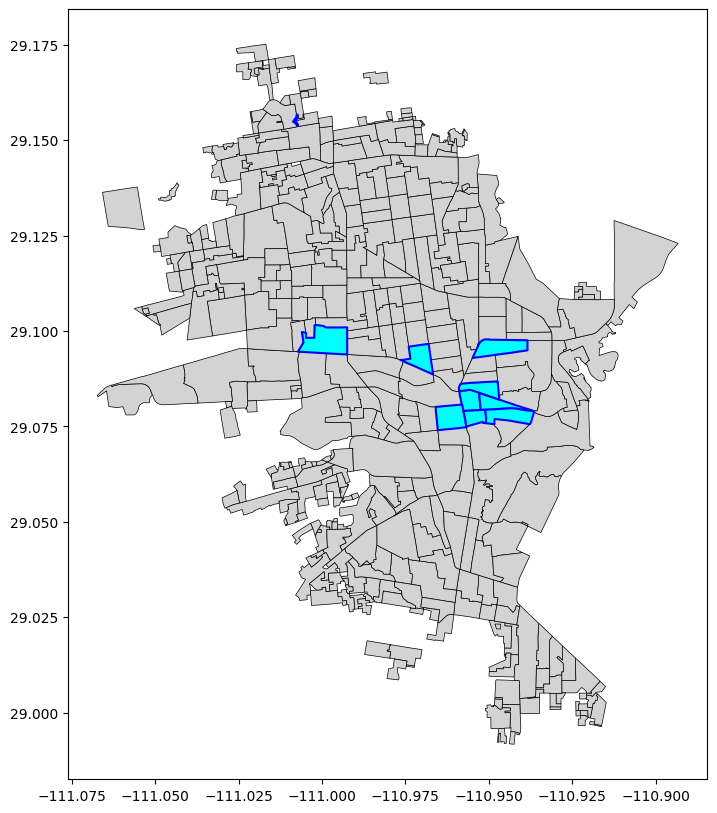

In [62]:
total_baches_ageb['es_destacada'] = total_baches_ageb['CVEGEO'].isin(baches_pob)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
total_baches_ageb[~total_baches_ageb['es_destacada']].plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)  # Colonias no destacadas
total_baches_ageb[total_baches_ageb['es_destacada']].plot(ax=ax, color='cyan', edgecolor='blue', linewidth=1.5)        # Colonias destacadas

plt.show()
total_baches_ageb = total_baches_ageb.drop(columns=['es_destacada'])